<a href="https://colab.research.google.com/github/raveesharanamukage/Basic-Deep-Learning-Projects/blob/main/Forecast%20Revenue%20By%20MealPeriod/LSTM_Lunch_RC_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#column_names=['Date','MealPeriod','RevenueCentreName','CheckTotal']
df=pd.read_csv('/content/drive/MyDrive/Datasets/hotel/Datasets/Lunch_RevenueCenter_3.csv',parse_dates=['Date'])
print(df.head())
print(df.info()) #Consice summary of the DataFrame
print(df.describe())

        Date MealPeriod RevenueCentreName  CheckTotal
0 2023-01-01      Lunch   RevenueCenter_3       763.0
1 2023-01-02      Lunch   RevenueCenter_3       546.0
2 2023-01-03      Lunch   RevenueCenter_3       693.0
3 2023-01-04      Lunch   RevenueCenter_3       839.5
4 2023-01-05      Lunch   RevenueCenter_3       707.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               486 non-null    datetime64[ns]
 1   MealPeriod         486 non-null    object        
 2   RevenueCentreName  486 non-null    object        
 3   CheckTotal         486 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 15.3+ KB
None
                                Date   CheckTotal
count                            486   486.000000
mean   2023-08-31 11:59:59.999999744  1760.782366
min            

In [ ]:
df['CheckTotal'] = df['CheckTotal'].replace(0, np.nan).interpolate()

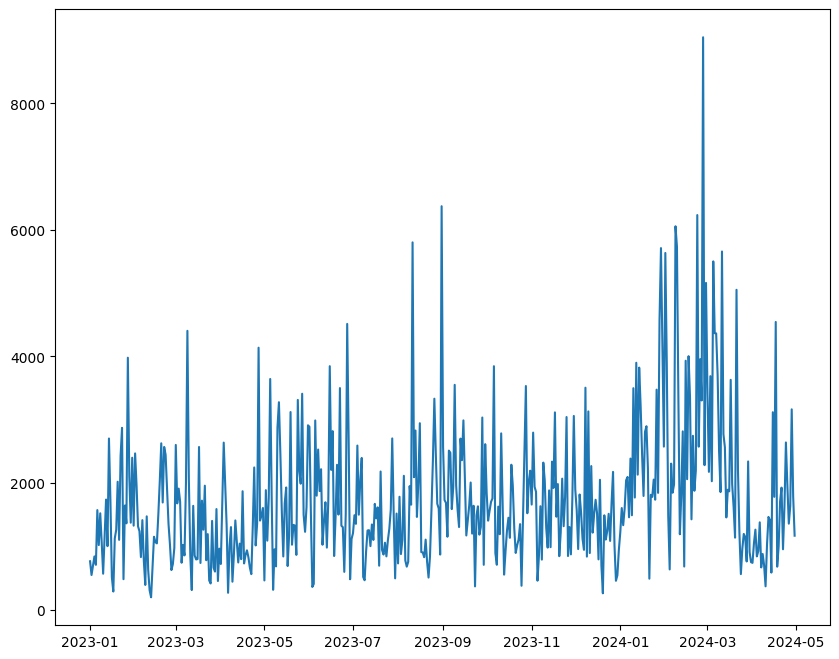

In [ ]:
#Visualize the revenue without considering meal period,revenue centre
plt.figure(figsize=(10,8))
plt.plot(df['Date'],df['CheckTotal'])
plt.show()

Feature Engineering for Dubai

In [ ]:

df['day_of_week'] = df['Date'].dt.dayofweek  # 0=Mon, 4=Fri, 5=Sat
df['is_weekend'] = df['day_of_week'].isin([4, 5]).astype(int)  # UAE weekend
df['month'] = df['Date'].dt.month
df['is_high_season'] = df['month'].isin([10, 11, 12, 1, 2, 3, 4]).astype(int)  # Oct-Apr




In [ ]:
df['is_ramadan'] = 0
df.loc[(df['Date'].between('2023-03-22', '2023-04-20')) |
       (df['Date'].between('2024-03-10', '2024-04-08')), 'is_ramadan'] = 1

In [ ]:
#dd UAE holidays
from pandas.tseries.holiday import Holiday, nearest_workday
from pandas.tseries.offsets import CustomBusinessDay
holidays = [
    Holiday('UAE National Day', month=12, day=2, observance=nearest_workday),
    # Add Eid al-Fitr, Eid al-Adha, etc., based on lunar calendar
]
df['is_holiday'] = df['Date'].isin(holidays).astype(int)

In [ ]:
#Lag and Rolling Features
df['lag_1'] = df['CheckTotal'].shift(1)  # Previous day
df['lag_7'] = df['CheckTotal'].shift(7)  # Previous week
df['rolling_mean_7'] = df['CheckTotal'].rolling(window=7).mean()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['CheckTotal', 'day_of_week', 'is_weekend','lag_1','is_high_season','rolling_mean_7', 'is_ramadan', 'lag_7']
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

In [ ]:
df_scaled.dropna(inplace=True)
df_scaled

,CheckTotal,day_of_week,is_weekend,lag_1,is_high_season,rolling_mean_7,is_ramadan,lag_7
7,0.149952,1.000000,0.0,0.093226,1.0,0.087350,0.0,0.064297
8,0.098141,0.000000,0.0,0.149952,1.0,0.105721,0.0,0.039776
9,0.042093,0.166667,0.0,0.098141,1.0,0.101222,0.0,0.056387
10,0.109837,0.333333,0.0,0.042093,1.0,0.112835,0.0,0.072942
11,0.174501,0.500000,0.0,0.109837,1.0,0.149516,0.0,0.057969
...,...,...,...,...,...,...,...,...
481,0.131476,0.666667,1.0,0.200350,1.0,0.275103,0.0,0.090909
482,0.163512,0.833333,1.0,0.131476,1.0,0.272649,0.0,0.171309
483,0.335612,1.000000,0.0,0.163512,1.0,0.316648,0.0,0.195830
484,0.180406,0.000000,0.0,0.335612,1.0,0.346456,0.0,0.085711


Sesonality Analysis

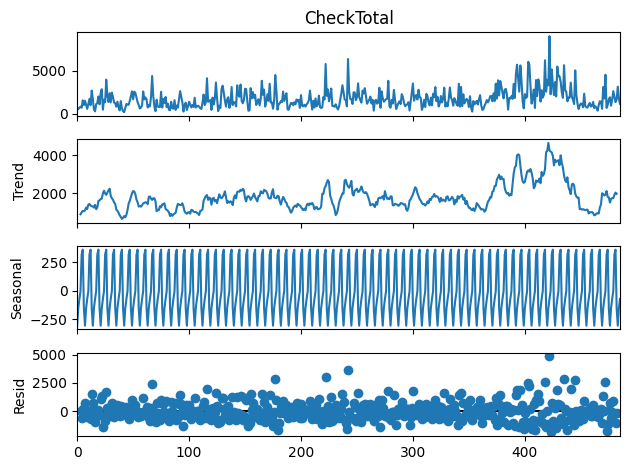

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['CheckTotal'].dropna(), period=7, model='additive')
decomposition.plot()
plt.show()

### Data Preparation for LSTM

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predict CheckTotal
    return np.array(X), np.array(y)

seq_length = 7
data = df_scaled.values
X, y = create_sequences(data, seq_length)
X = X.reshape((X.shape[0], X.shape[1], len(features)))  # [samples, timesteps, features]

In [ ]:
#Train test validation split
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 100)         │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,851 (288.48 KB)

 Trainable params: 73,851 (288.48 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=16, callbacks=[early_stopping])

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0159 - val_loss: 0.0502
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0127 - val_loss: 0.0576
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0117 - val_loss: 0.0703
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0096 - val_loss: 0.0707
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0113 - val_loss: 0.0585
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - val_loss: 0.0626
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - val_loss: 0.0610
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0111 - val_loss: 0.0661
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0097 - val_loss: 0.0714
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0087 - val_loss: 0.0629
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0123 - val_loss: 0.0662


### Evaluation and Diagnostic

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.hstack([y_pred, np.zeros((y_pred.shape[0], len(features)-1))]))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1))]))[:, 0]

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2=r2_score(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%,R²:{r2}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step
RMSE: 949.8184428768762, MAE: 726.630878132768, MAPE: 63.13042984902134%,R²:0.04717967101903153


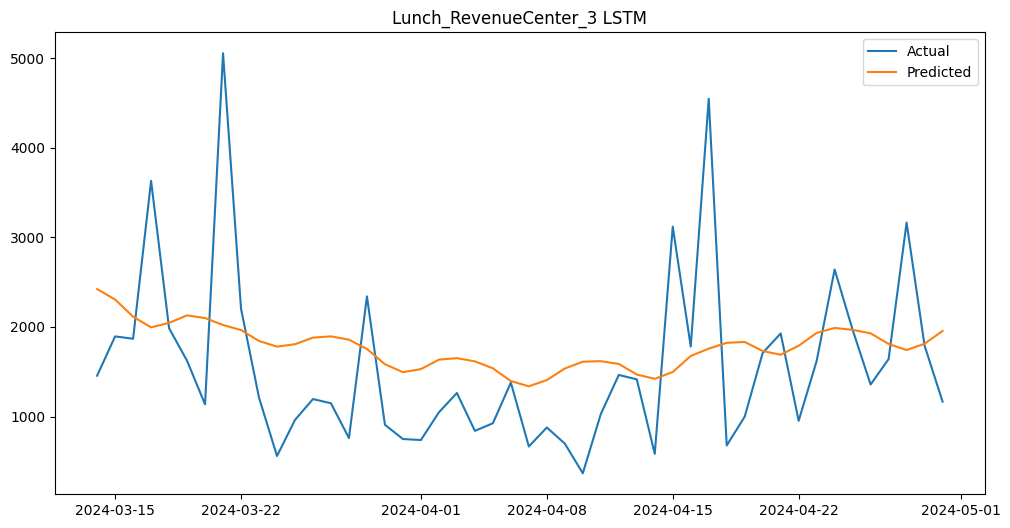

In [ ]:
#Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test_inv):], y_test_inv, label='Actual')
plt.plot(df['Date'].iloc[-len(y_pred_inv):], y_pred_inv, label='Predicted')
name=f'{df["MealPeriod"][0]}_{df["RevenueCentreName"][0]} LSTM'
plt.title(name)
plt.legend()
plt.show()

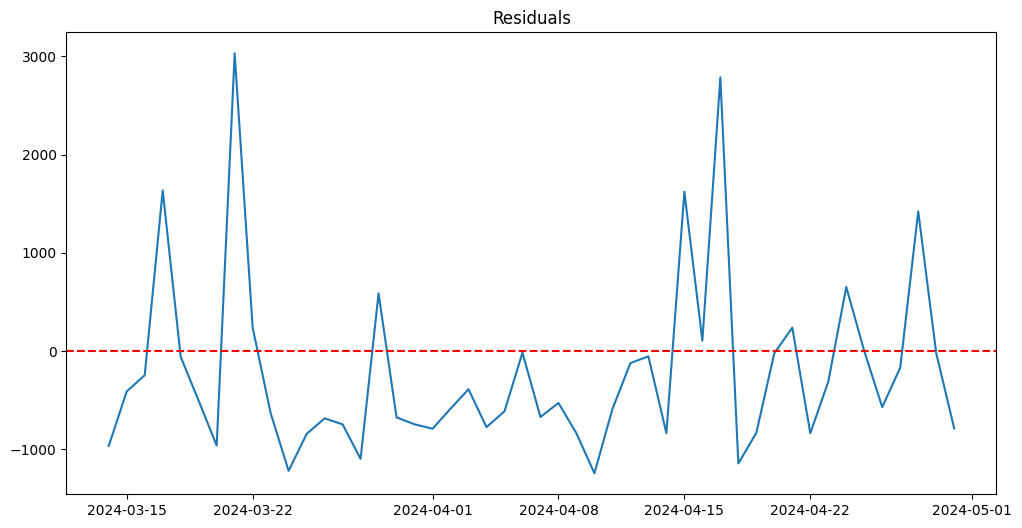

In [ ]:
residuals = y_test_inv - y_pred_inv
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(residuals):], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals')
plt.show()

In [ ]:
# Prepare future dates (May 1, 2024 - Jul 29, 2024)
future_dates = pd.date_range(start='2024-05-01', end='2024-07-29', freq='D')
future_df = pd.DataFrame({'Date': future_dates})

# Generate future features
future_df['day_of_week'] = future_df['Date'].dt.dayofweek
future_df['is_weekend'] = future_df['day_of_week'].isin([4, 5]).astype(int)
future_df['month'] = future_df['Date'].dt.month
future_df['is_high_season'] = future_df['month'].isin([10, 11, 12, 1, 2, 3, 4]).astype(int)
future_df['is_ramadan'] = 0  # No Ramadan in May-Jul 2024

future_df.set_index('Date', inplace=True)

# Initialize forecast
last_sequence = data[-seq_length:].reshape(1, seq_length, len(features))
forecast = []

# Iterative forecasting
for i in range(len(future_df)):
    pred = model.predict(last_sequence, verbose=0)
    forecast.append(pred[0, 0])

    # Update sequence with new prediction and future features
    # Calculate lag_1, lag_7, and rolling_mean_7 based on the forecast
    lag_1_val = forecast[-1] if len(forecast) > 0 else last_sequence[0, -1, features.index('CheckTotal')]
    lag_7_val = forecast[-7] if len(forecast) >= 7 else last_sequence[0, -7, features.index('CheckTotal')]
    rolling_mean_7_val = np.mean(forecast[-7:]) if len(forecast) >= 7 else np.mean(last_sequence[0, -7:, features.index('CheckTotal')])

    new_row = np.array([pred[0, 0], # CheckTotal (predicted)
                        future_df['day_of_week'].iloc[i],
                        future_df['is_weekend'].iloc[i],
                        lag_1_val, # lag_1 (previous day's forecast)
                        future_df['is_high_season'].iloc[i],
                        rolling_mean_7_val, # rolling_mean_7 (mean of last 7 forecasts)
                        future_df['is_ramadan'].iloc[i],
                        lag_7_val # lag_7 (previous week's forecast)
                        ])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, :] = new_row

# Inverse transform predictions
forecast_array = np.array(forecast).reshape(-1, 1)
forecast_padded = np.hstack([forecast_array, np.zeros((len(forecast), len(features)-1))])
forecast_inv = scaler.inverse_transform(forecast_padded)[:, 0]

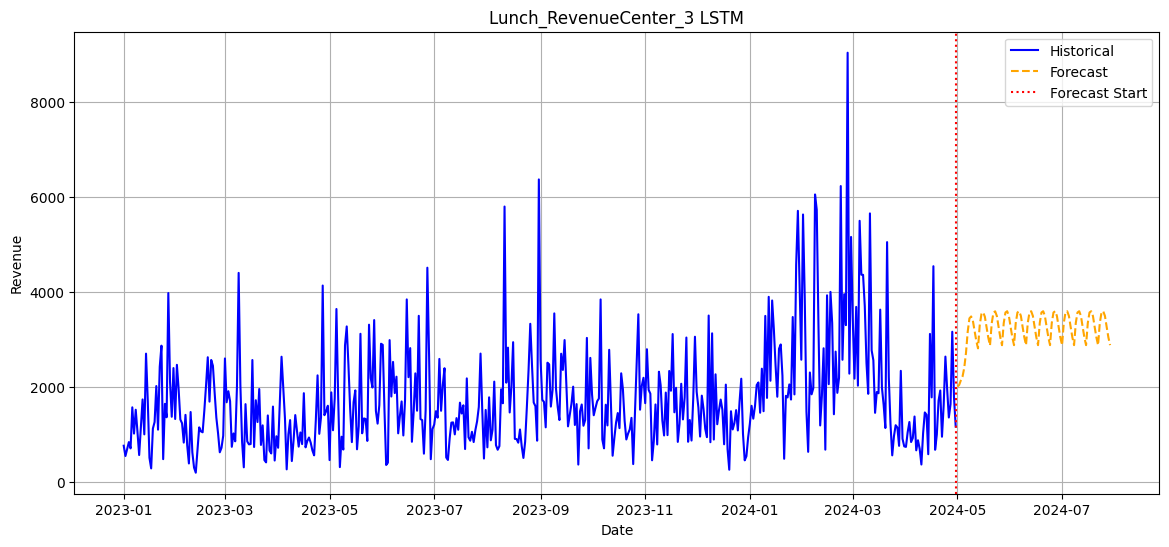

In [ ]:
# Combine historical and forecast data
historical_df = df[['Date', 'CheckTotal']].set_index('Date')
forecast_df = pd.DataFrame({'CheckTotal': forecast_inv}, index=future_dates)
combined_df = pd.concat([historical_df, forecast_df])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(historical_df.index, historical_df['CheckTotal'], label='Historical', color='blue')
plt.plot(forecast_df.index, forecast_df['CheckTotal'], label='Forecast', color='orange', linestyle='--')
plt.axvline(x=pd.to_datetime('2024-04-30'), color='red', linestyle=':', label='Forecast Start')
name=f'{df["MealPeriod"][0]}_{df["RevenueCentreName"][0]} LSTM'
plt.title(name)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()